# DriveThru Suggested Sell Recommender
DriveThru Suggested Sell Recommender built using Apache MXnet

## Initialization
import libraries

In [1]:
import os
import boto3
import mxnet as mx
import pandas as pd
import numpy as np
import s3fs
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import logging

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(filename='./drivethru_log',level=logging.DEBUG)

## Data Preparation
Load data from S3 bucket

In [7]:
bucket = ...
prefix = '/path/to/data/''
model_prefix = ...
batch_size = 32000
num_epoch = 100
num_gpus = range(8)
context = [mx.gpu(int(i)) for i in num_gpus] if num_gpus else [mx.cpu()]
model_checkpoint_interval = 5

In [ ]:
# Split and download training data from s3
session = boto3.Session(
    aws_access_key_id=...
    aws_secret_access_key=...
)
s3_client = session.client('s3', verify=False)


df_list = []
keys = []
resp = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
for obj in resp['Contents']:
    keys.append(obj['Key'])
keys_dedup = list(dict.fromkeys(keys))

In [ ]:
print(keys_dedup)

In [ ]:
for key in keys_dedup:
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    df = pd.read_json(obj['Body'], orient='columns', lines=True)
    df_list.append(df)

data = pd.concat(df_list)

In [13]:
train, test = train_test_split(data, test_size=0.001, random_state=100)

In [14]:
n_plus, n_time, n_bkids, n_weather, n_feels = int(train['pluids'].apply(lambda row: max(row)).max()), \
                                              int(train['timeidx'].max()), int(train['bkidx'].max()), \
                                              int(train['weatheridx'].max()), int(train['feelsBucket'].max())

In [15]:
n_plus, n_time, n_bkids, n_weather, n_feels

(522, 167, 126, 35, 20)

Load pandas dataframe into mxnet ndarray

In [15]:
X_train = mx.io.NDArrayIter(data={'pluids': np.array(train['pluids'].values.tolist(), dtype=int),
                                  'bkidx': train['bkidx'].values,
                                  'timeidx': train['timeidx'].values,
                                  'feels_bucket': train['feelsBucket'].values,
                                  'weatheridx': train['weatheridx'].values}, 
                            label={'output_label': train['label'].values}, 
                            batch_size=batch_size,
                            shuffle=True)
X_eval = mx.io.NDArrayIter(data={'pluids': np.array(test['pluids'].values.tolist(), dtype=int),
                                 'bkidx': test['bkidx'].values,
                                 'timeidx': test['timeidx'].values,
                                 'feels_bucket': test['feelsBucket'].values,
                                 'weatheridx': test['weatheridx'].values}, 
                            label={'output_label': test['label'].values}, 
                            batch_size=batch_size,
                            shuffle=True)
y_true = mx.symbol.Variable('output_label')

## Build Model

In [ ]:
from mxnet.gluon import nn, rnn
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x):
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x)
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        # att shape: [batch_size,  att_hops, seq_len]
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)

        return output, att

In [16]:
pluids = mx.symbol.Variable('pluids')
bkidx = mx.symbol.Variable('bkidx')
timeidx = mx.symbol.Variable('timeidx')
feels_bucket = mx.symbol.Variable('feels_bucket')
weatheridx = mx.symbol.Variable('weatheridx')
plu_embed = mx.symbol.Embedding(data=pluids, input_dim=n_plus, output_dim=50, name='plu_embed')
bkidx_embed = mx.symbol.Embedding(data=bkidx, input_dim=n_bkids, output_dim=100, name='bkid_embed')
time_embed = mx.symbol.Embedding(data=timeidx, input_dim=n_time, output_dim=100, name='time_embed')
feels_embed = mx.symbol.Embedding(data=feels_bucket, input_dim=n_feels, output_dim=100, name='feels_embed')
weather_embed = mx.symbol.Embedding(data=weatheridx, input_dim=n_weather, output_dim=100, name='weather_embed')

In [18]:
stacked_rnn_cells = mx.rnn.SequentialRNNCell()
stacked_rnn_cells.add(mx.rnn.BidirectionalCell(mx.rnn.GRUCell(num_hidden=50, prefix="gru_l"),
                                               mx.rnn.GRUCell(num_hidden=50, prefix="gru_r")))
stacked_out, _ = stacked_rnn_cells.unroll(length=5, inputs=plu_embed, merge_outputs=True, layout="NTC")

In [19]:
attention_out, att = SelfAttention(100, 1).hybrid_forward(mx.sym, stacked_out)
flatten = mx.symbol.flatten(attention_out, "flatten")

In [20]:
context_features = mx.symbol.broadcast_mul((1 + bkidx_embed + time_embed + weather_embed + feels_embed), 
                                           flatten, name='latent_cross')
ac1 = mx.symbol.Activation(data=context_features, act_type="relu", name="relu1")
dropout1 = mx.symbol.Dropout(data=ac1, p=0.3, name="dropout1")
fc1 = mx.symbol.FullyConnected(data=dropout1, num_hidden=int(n_plus), name='fc1')
rec_model = mx.symbol.SoftmaxOutput(data=fc1, label=y_true, name='output')

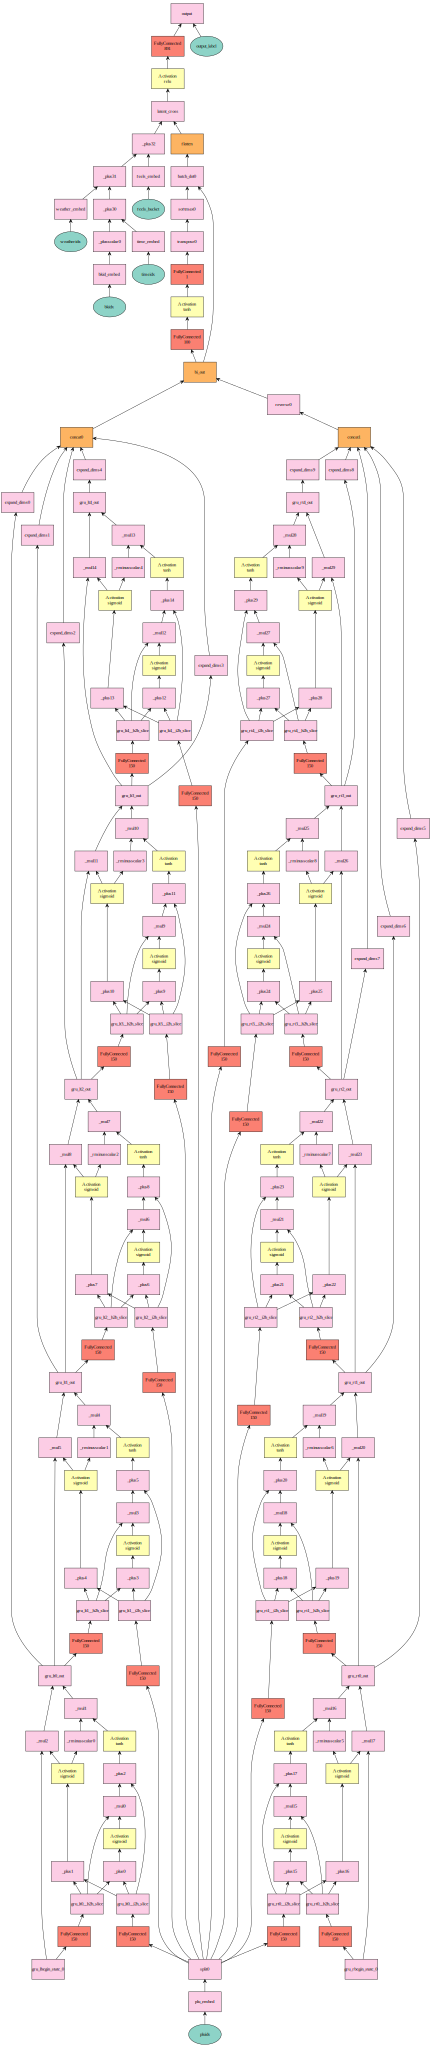

In [19]:
mx.visualization.plot_network(rec_model, save_format="pdf", title="drivethru_rec")

In [17]:
graph = mx.visualization.plot_network(rec_model, save_format="pdf", title="bi_self_atteion_rec")

In [18]:
graph.render()

'bi_self_atteion_rec.gv.pdf'

In [23]:
mx.visualization.print_summary(rec_model)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
bkidx(null)                                                                 0                                           
________________________________________________________________________________________________________________________
bkid_embed(Embedding)                                                       234122      bkidx                           
________________________________________________________________________________________________________________________
_plusscalar1(_plus_scalar)                                                  0           bkid_embed                      
________________________________________________________________________________________________________________________
time_embed(Embedding)           

## Train Model

In [21]:
mod = mx.mod.Module(symbol=rec_model, 
                    data_names=['pluids', 'bkidx', 'timeidx', 'feels_bucket', 'weatheridx'], 
                    label_names=['output_label'],
                    context=context
                   )

In [22]:
mod.fit(train_data=X_train, 
        num_epoch=num_epoch, 
        initializer=mx.init.Xavier(rnd_type="gaussian"),
        optimizer='adagrad',
        eval_metric=['accuracy'],
        validation_metric=['accuracy', mx.metric.TopKAccuracy(3)],
        eval_data=X_eval, 
        batch_end_callback=mx.callback.Speedometer(batch_size, 500),
        epoch_end_callback = None if model_prefix==None else mx.callback.do_checkpoint(model_prefix, 
                                                                                       model_checkpoint_interval))

In [10]:
loaded = mx.mod.Module.load(prefix=model_prefix,
                            epoch=25,
#                             load_optimizer_states=True,
                            data_names=['pluids', 'bkidx', 'timeidx', 'feels_bucket', 'weatheridx'], 
                            label_names=['output_label'],
                            context=context
                            )

In [ ]:
loaded.fit(train_data=X_train, 
           begin_epoch=25,
            num_epoch=200, 
#             initializer=mx.init.Normal(),
            optimizer='adagrad',
            eval_metric='accuracy',
            validation_metric=['accuracy', mx.metric.TopKAccuracy(3)],
            eval_data=X_eval, 
            batch_end_callback=mx.callback.Speedometer(batch_size, 500),
            epoch_end_callback = None if model_prefix==None else mx.callback.do_checkpoint(model_prefix, 5))

## Model save and load

In [ ]:
mod.save_checkpoint(prefix, 9, save_optimizer_states=True)

In [68]:
load = mx.model.FeedForward.load(prefix=prefix, epoch=9, ctx=mx.gpu())